In [1]:
import os, sys
sys.path.append('C:\\Users\\matthias\\Documents\\myProjects\\TU_Bibliothek\\code\\baseline-extract')
#from src.inference.models import LineDetector

from src.segmentation.gcn_model import GCN
from src.data.dataset_line_rider import DatasetLineRider
from src.data.dataset_inference import DatasetInference
#from src.inference.models import LineDetector
from src.utils.distances import get_median_diff, d2, get_smallest_distance

import torch
import math
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
def is_in_box(point, left, top, width, height):
    x = point[0]
    y = point[1]

    if left < x < left + width:
        if top < y < top + height:
            return True

    return False


def contains_start_point(points, bl_stats):
    comp_contains_sp = []
    for n, bl_s in enumerate(bl_stats):

        left = bl_s[0]
        top = bl_s[1]
        width = bl_s[2]
        height = bl_s[3]

        if width > height:
            left -= 5
            width += 10
        else:
            top -= 5
            height += 10

        contains_sp_switch = False
        for p in points:
            if is_in_box(p, left, top, width, height):
                comp_contains_sp.append(True)
                contains_sp_switch = True
                break

        if not contains_sp_switch:
            comp_contains_sp.append(False)

    return comp_contains_sp

class LineDetector:
    """
    Loads the line rider model for inference.
    """
    def __init__(self, config: dict):
        self.config = config
        line_rider_weights = config['line_rider']['weights']
        line_finder_weights = config['line_finder']['weights']
        self.device_lr = torch.device('cuda:' + str(config['line_rider']['device']) if torch.cuda.is_available() else 'cpu')
        self.device_lf = torch.device('cuda:' + str(config['line_finder']['device']) if torch.cuda.is_available() else 'cpu')
        num_classes = config['line_finder']['num_classes']
        backbone = config['line_finder']['backbone']

        print('## Load Line Rider:')
        self.line_rider = self.load_line_rider_model(line_rider_weights, self.device_lr)
        print('## Load Line Finder:')
        self.line_finder_seg = self.load_line_finder_model(line_finder_weights, self.device_lf, num_classes, backbone)
        print('## Loaded!')


    def load_line_rider_model(self, weights, device):
        model = torch.load(weights, map_location=device)
        model.to(device)
        model.eval()
        model.device = device

        return model

    def load_line_finder_model(self, weights, device, num_classes, backbone):
        seg_model = GCN(n_classes=num_classes, resnet_depth=backbone)
        seg_model.load_state_dict(torch.load(weights, map_location=device))
        seg_model.to(device)
        seg_model.eval()

        return seg_model

    def segmentation_postprocessing(self, array: np.array, sigma, threshold, morph_close_size, erode_size):
        out = cv2.GaussianBlur(array, (int(3 * sigma) * 2 + 1, int(3 * sigma) * 2 + 1), sigma)
        out = (out > threshold) * 1.0
        out = cv2.morphologyEx(out, cv2.MORPH_CLOSE, (morph_close_size, morph_close_size))
        out = cv2.erode(out, (erode_size, erode_size), iterations=1)

        return out

    def extract_start_points_and_angles(self, seg: np.array) -> tuple:
        segmentation = np.transpose(seg[0], (1, 2, 0))

        probs_start_points = segmentation[:, :, 3]
        probs_end_points = segmentation[:, :, 4]
        probs_baselines = segmentation[:, :, 0]
        probs_border = segmentation[:, :, 1]

        # Postprozessing parameters
        sigma = 0.3
        threshold = 0.99
        morph_close_size = 3
        erode_size = 3

        # Extract baselines
        bl = self.segmentation_postprocessing(probs_baselines, sigma, threshold, morph_close_size, erode_size)
        _, bl_labels, bl_stats, bl_centroids = cv2.connectedComponentsWithStats(bl.astype(np.uint8))

        # Extract baseline_borders
        border = self.segmentation_postprocessing(probs_border, sigma, threshold, morph_close_size, erode_size)
        _, border_labels, _, _ = cv2.connectedComponentsWithStats(border.astype(np.uint8))

        # Extract start points
        sp = self.segmentation_postprocessing(probs_start_points, sigma, threshold, morph_close_size, erode_size)
        _, _, _, start_points = cv2.connectedComponentsWithStats(sp.astype(np.uint8))

        # Extract end points
        ep = self.segmentation_postprocessing(probs_end_points, sigma, threshold, morph_close_size, erode_size)
        _, _, _, end_points = cv2.connectedComponentsWithStats(ep.astype(np.uint8))

        # Compute the angles and match start and end points
        probs_sum = probs_start_points + probs_end_points + probs_baselines
        ps = cv2.GaussianBlur(probs_sum, (int(3 * sigma) * 2 + 1, int(3 * sigma) * 2 + 1), sigma)
        ps = (ps > threshold) * 1.0
        ps = cv2.morphologyEx(ps, cv2.MORPH_OPEN, (3, 3))

        _, labels, stats, _ = cv2.connectedComponentsWithStats(ps.astype(np.uint8))
        
        # stats is a matrix where for every label l the vector stats[l] is given by:
        # [leftmost (x) coordinate, topmost (y) coordinate, width of bounding box, height of bouinding box, area]
        # see https://stackoverflow.com/questions/35854197/how-to-use-opencvs-connected-components-with-stats-in-python

        # Assign labels to the start and end points
        # [1:] because the background is also a component
        sp_labels = {labels[(int(p[1]), int(p[0]))]: p for p in start_points[1:]}
        ep_labels = {labels[(int(p[1]), int(p[0]))]: p for p in end_points[1:]}

        label_list = sp_labels.keys()
        angles = {l: np.arctan(stats[l][3] / stats[l][2]) for l in label_list}
        
        bl_out_truth = contains_start_point(start_points, bl_stats)

        new_sp = []
        new_angles = []

        for n, bl_s in enumerate(bl_stats):
            if not bl_out_truth[n]:

                left = bl_s[0]
                top = bl_s[1]
                width = bl_s[2]
                height = bl_s[3]
                area = bl_s[4]

                if area < 3000*self.config['data']['img_size']/1024:
                    continue

                if width > height:
                    for y in range(top, top + height):
                        if bl_labels[y, left + 1] == n:
                            new_sp.append(np.array([left, y]))
                            new_angles.append(0.0)
                            break
                else:
                    y_direction = 0

                    for x in range(left, left + width):
                        if bl_labels[top + 10, x] == n:
                            y_direction = -1
                            break
                        elif border_labels[top + 10, x] != 0:
                            y_direction = 1
                            break

                    if y_direction < 0:  # from bottom up
                        for x in range(left, left + width):
                            if bl_labels[top + height - 1, x] == n:
                                new_sp.append(np.array([x, top + height - 1]))
                                new_angles.append(math.pi / 2)
                                break
                    elif y_direction > 0:  # from up to down
                        for x in range(left, left + width):
                            if bl_labels[top + 1, x] == n:
                                new_sp.append(np.array([x, top + 1]))
                                new_angles.append(-math.pi / 2)
                                break
        
        sp_buff = []
        angle_buff = []
    
        for n in range(len(new_sp)):
            x = new_sp[n][0]
            y = new_sp[n][1]
            
            d_min = 1e10
            for l in label_list:
                d = np.sqrt(pow(x-sp_labels[l][0], 2) + pow(y-sp_labels[l][1], 2))
                if d > 0:
                    d_min = min(d_min, d)
            if d_min > 5:
                sp_buff.append(new_sp[n])
                angle_buff.append(new_angles[n])

        new_sp = sp_buff
        new_angles = angle_buff

        new_sp_dict = {l+max(label_list)+1: new_sp[l] for l in range(0, len(new_sp))}
        new_angle_dict = {l+max(label_list)+1: new_angles[l] for l in range(0, len(new_angles))}
        
        sp_labels.update(new_sp_dict)
        angles.update(new_angle_dict)
        
        return sp_labels, ep_labels, angles, label_list

    def extract_baselines(self, image: torch.tensor):
        image = image.unsqueeze(0).to(self.device_lf)
        seg_out = self.line_finder_seg(image)[0]

        image_seg = torch.cat([image[:, 0:1, :, :], seg_out[:, [0, 1], :, :]], dim=1).detach()

        start_points, end_points, angles, label_list = self.extract_start_points_and_angles(seg_out.cpu().detach().numpy())

        sp_values = torch.tensor(list(start_points.values())).to(self.device_lr)

        baselines = []
        ep_label_list = end_points.keys()

        for l in label_list:
            sp = torch.tensor(start_points[l]).to(self.device_lr)
            angle = torch.tensor(angles[l]).to(self.device_lr)

            # Compute box size
            box_size = int(get_smallest_distance(sp, sp_values))
            box_size = max(10, min(48, box_size))
            if box_size == 0:
                box_size = min(10, max(32, get_median_diff(start_points) / 2.0))

            box_size = torch.tensor(box_size).double()

            if l in ep_label_list:
                ep = torch.tensor(end_points[l]).to(self.device_lr)

                baseline, _, _, _ = self.line_rider(img=image_seg, box_size=box_size, sp=sp, angle_0=angle)

                baseline[-1] = ep
            else:
                baseline, _, _, _ = self.line_rider(img=image_seg, box_size=box_size, sp=sp, angle_0=angle)

            baselines.append(baseline)

        return baselines

In [3]:
config = {
  "line_rider": {
    "weights": "..\\trained_models\\line_rider\\line_rider_page_end_seperate.pt",
    "device": 1
  },
  "line_finder": {
    "weights": "..\\trained_models\\segmentation\\GCN_1024_cBAD_resnext50.pt",
    "device": 1,
    "num_classes": 6,
    "backbone": 50
  },
  "random_seed": 42,
  "output_folder": "..\\data\\sample_out",
  "data": {
    "input_folder": "..\\data\\cBAD-ICDAR2019\\test",
    "img_size": 1024
  }
}

In [4]:
ld = LineDetector(config)

## Load Line Rider:


c:\users\matthias\documents\myprojects\tu_bibliothek\code\baseline-extract\venv\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'src.model.line_rider.LineRider' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


## Load Line Finder:


RuntimeError: Error(s) in loading state_dict for GCN:
	size mismatch for gcn1.conv_l1.weight: copying a param with shape torch.Size([12, 2048, 7, 1]) from checkpoint, the shape in current model is torch.Size([19, 2048, 5, 1]).
	size mismatch for gcn1.conv_l1.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for gcn1.conv_l2.weight: copying a param with shape torch.Size([12, 12, 1, 7]) from checkpoint, the shape in current model is torch.Size([19, 19, 1, 5]).
	size mismatch for gcn1.conv_l2.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for gcn1.conv_r1.weight: copying a param with shape torch.Size([12, 2048, 1, 7]) from checkpoint, the shape in current model is torch.Size([19, 2048, 1, 5]).
	size mismatch for gcn1.conv_r1.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for gcn1.conv_r2.weight: copying a param with shape torch.Size([12, 12, 7, 1]) from checkpoint, the shape in current model is torch.Size([19, 19, 5, 1]).
	size mismatch for gcn1.conv_r2.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for gcn2.conv_l1.weight: copying a param with shape torch.Size([12, 1024, 7, 1]) from checkpoint, the shape in current model is torch.Size([19, 1024, 5, 1]).
	size mismatch for gcn2.conv_l1.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for gcn2.conv_l2.weight: copying a param with shape torch.Size([12, 12, 1, 7]) from checkpoint, the shape in current model is torch.Size([19, 19, 1, 5]).
	size mismatch for gcn2.conv_l2.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for gcn2.conv_r1.weight: copying a param with shape torch.Size([12, 1024, 1, 7]) from checkpoint, the shape in current model is torch.Size([19, 1024, 1, 5]).
	size mismatch for gcn2.conv_r1.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for gcn2.conv_r2.weight: copying a param with shape torch.Size([12, 12, 7, 1]) from checkpoint, the shape in current model is torch.Size([19, 19, 5, 1]).
	size mismatch for gcn2.conv_r2.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for gcn3.conv_l1.weight: copying a param with shape torch.Size([12, 512, 7, 1]) from checkpoint, the shape in current model is torch.Size([19, 512, 5, 1]).
	size mismatch for gcn3.conv_l1.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for gcn3.conv_l2.weight: copying a param with shape torch.Size([12, 12, 1, 7]) from checkpoint, the shape in current model is torch.Size([19, 19, 1, 5]).
	size mismatch for gcn3.conv_l2.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for gcn3.conv_r1.weight: copying a param with shape torch.Size([12, 512, 1, 7]) from checkpoint, the shape in current model is torch.Size([19, 512, 1, 5]).
	size mismatch for gcn3.conv_r1.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for gcn3.conv_r2.weight: copying a param with shape torch.Size([12, 12, 7, 1]) from checkpoint, the shape in current model is torch.Size([19, 19, 5, 1]).
	size mismatch for gcn3.conv_r2.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for gcn4.conv_l1.weight: copying a param with shape torch.Size([12, 256, 7, 1]) from checkpoint, the shape in current model is torch.Size([19, 256, 5, 1]).
	size mismatch for gcn4.conv_l1.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for gcn4.conv_l2.weight: copying a param with shape torch.Size([12, 12, 1, 7]) from checkpoint, the shape in current model is torch.Size([19, 19, 1, 5]).
	size mismatch for gcn4.conv_l2.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for gcn4.conv_r1.weight: copying a param with shape torch.Size([12, 256, 1, 7]) from checkpoint, the shape in current model is torch.Size([19, 256, 1, 5]).
	size mismatch for gcn4.conv_r1.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for gcn4.conv_r2.weight: copying a param with shape torch.Size([12, 12, 7, 1]) from checkpoint, the shape in current model is torch.Size([19, 19, 5, 1]).
	size mismatch for gcn4.conv_r2.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine1.bn.weight: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine1.bn.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine1.bn.running_mean: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine1.bn.running_var: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine1.conv1.weight: copying a param with shape torch.Size([12, 12, 3, 3]) from checkpoint, the shape in current model is torch.Size([19, 19, 3, 3]).
	size mismatch for refine1.conv1.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine1.conv2.weight: copying a param with shape torch.Size([12, 12, 3, 3]) from checkpoint, the shape in current model is torch.Size([19, 19, 3, 3]).
	size mismatch for refine1.conv2.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine2.bn.weight: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine2.bn.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine2.bn.running_mean: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine2.bn.running_var: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine2.conv1.weight: copying a param with shape torch.Size([12, 12, 3, 3]) from checkpoint, the shape in current model is torch.Size([19, 19, 3, 3]).
	size mismatch for refine2.conv1.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine2.conv2.weight: copying a param with shape torch.Size([12, 12, 3, 3]) from checkpoint, the shape in current model is torch.Size([19, 19, 3, 3]).
	size mismatch for refine2.conv2.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine3.bn.weight: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine3.bn.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine3.bn.running_mean: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine3.bn.running_var: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine3.conv1.weight: copying a param with shape torch.Size([12, 12, 3, 3]) from checkpoint, the shape in current model is torch.Size([19, 19, 3, 3]).
	size mismatch for refine3.conv1.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine3.conv2.weight: copying a param with shape torch.Size([12, 12, 3, 3]) from checkpoint, the shape in current model is torch.Size([19, 19, 3, 3]).
	size mismatch for refine3.conv2.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine4.bn.weight: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine4.bn.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine4.bn.running_mean: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine4.bn.running_var: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine4.conv1.weight: copying a param with shape torch.Size([12, 12, 3, 3]) from checkpoint, the shape in current model is torch.Size([19, 19, 3, 3]).
	size mismatch for refine4.conv1.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine4.conv2.weight: copying a param with shape torch.Size([12, 12, 3, 3]) from checkpoint, the shape in current model is torch.Size([19, 19, 3, 3]).
	size mismatch for refine4.conv2.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine5.bn.weight: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine5.bn.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine5.bn.running_mean: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine5.bn.running_var: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine5.conv1.weight: copying a param with shape torch.Size([12, 12, 3, 3]) from checkpoint, the shape in current model is torch.Size([19, 19, 3, 3]).
	size mismatch for refine5.conv1.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine5.conv2.weight: copying a param with shape torch.Size([12, 12, 3, 3]) from checkpoint, the shape in current model is torch.Size([19, 19, 3, 3]).
	size mismatch for refine5.conv2.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine6.bn.weight: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine6.bn.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine6.bn.running_mean: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine6.bn.running_var: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine6.conv1.weight: copying a param with shape torch.Size([12, 12, 3, 3]) from checkpoint, the shape in current model is torch.Size([19, 19, 3, 3]).
	size mismatch for refine6.conv1.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine6.conv2.weight: copying a param with shape torch.Size([12, 12, 3, 3]) from checkpoint, the shape in current model is torch.Size([19, 19, 3, 3]).
	size mismatch for refine6.conv2.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine7.bn.weight: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine7.bn.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine7.bn.running_mean: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine7.bn.running_var: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine7.conv1.weight: copying a param with shape torch.Size([12, 12, 3, 3]) from checkpoint, the shape in current model is torch.Size([19, 19, 3, 3]).
	size mismatch for refine7.conv1.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for refine7.conv2.weight: copying a param with shape torch.Size([12, 12, 3, 3]) from checkpoint, the shape in current model is torch.Size([19, 19, 3, 3]).
	size mismatch for refine7.conv2.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for tconv1.tconv2d.weight: copying a param with shape torch.Size([12, 12, 3, 3]) from checkpoint, the shape in current model is torch.Size([19, 19, 3, 3]).
	size mismatch for tconv1.tconv2d.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for tconv2.tconv2d.weight: copying a param with shape torch.Size([12, 12, 3, 3]) from checkpoint, the shape in current model is torch.Size([19, 19, 3, 3]).
	size mismatch for tconv2.tconv2d.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for tconv3.tconv2d.weight: copying a param with shape torch.Size([12, 12, 3, 3]) from checkpoint, the shape in current model is torch.Size([19, 19, 3, 3]).
	size mismatch for tconv3.tconv2d.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([19]).
	size mismatch for tconv4.tconv2d.weight: copying a param with shape torch.Size([12, 6, 3, 3]) from checkpoint, the shape in current model is torch.Size([19, 6, 3, 3]).

In [6]:
ds = DatasetInference(1024, "..\\data\\cBAD-ICDAR2019\\test")

In [7]:
start_points, end_points, angles, label_list = ld.extract_start_points_and_angles(seg_out.unsqueeze(0).detach().numpy())

NameError: name 'seg_out' is not defined

In [8]:
start_points

NameError: name 'start_points' is not defined

In [9]:
angles

NameError: name 'angles' is not defined

In [10]:
sample = ds[0]
print('filename: {}'.format(sample['filename']))

filename: ..\data\cBAD-ICDAR2019\test\cPAS-0003.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


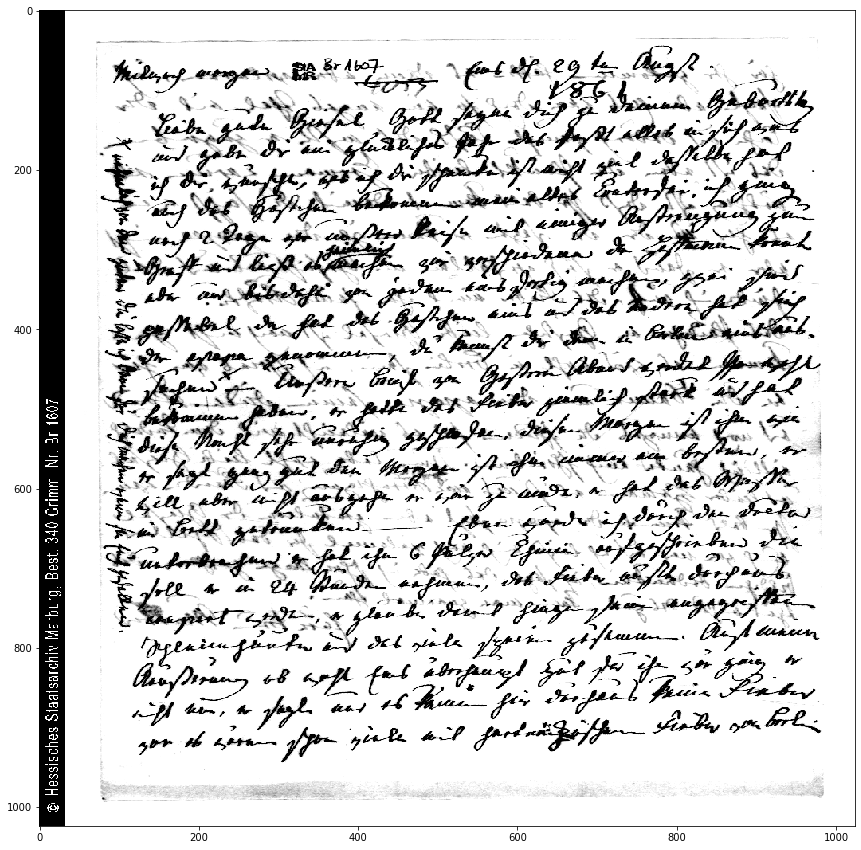

In [11]:
plt.figure(figsize=(15,15))
plt.imshow(sample['image'].permute(1,2,0).detach().numpy())

In [12]:
image = sample['image'].unsqueeze(0)
seg_out = ld.line_finder_seg(image)[0][0]

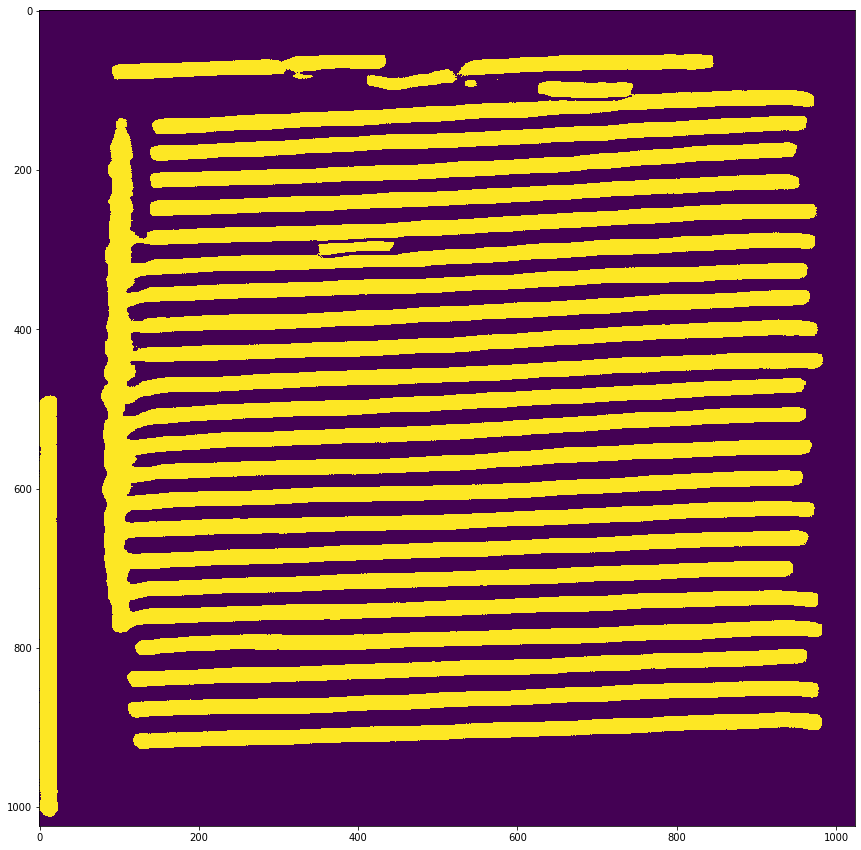

In [17]:
plt.figure(figsize=(15,15))
plt.imshow(seg_out[4,:,:].detach().numpy()>0.9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


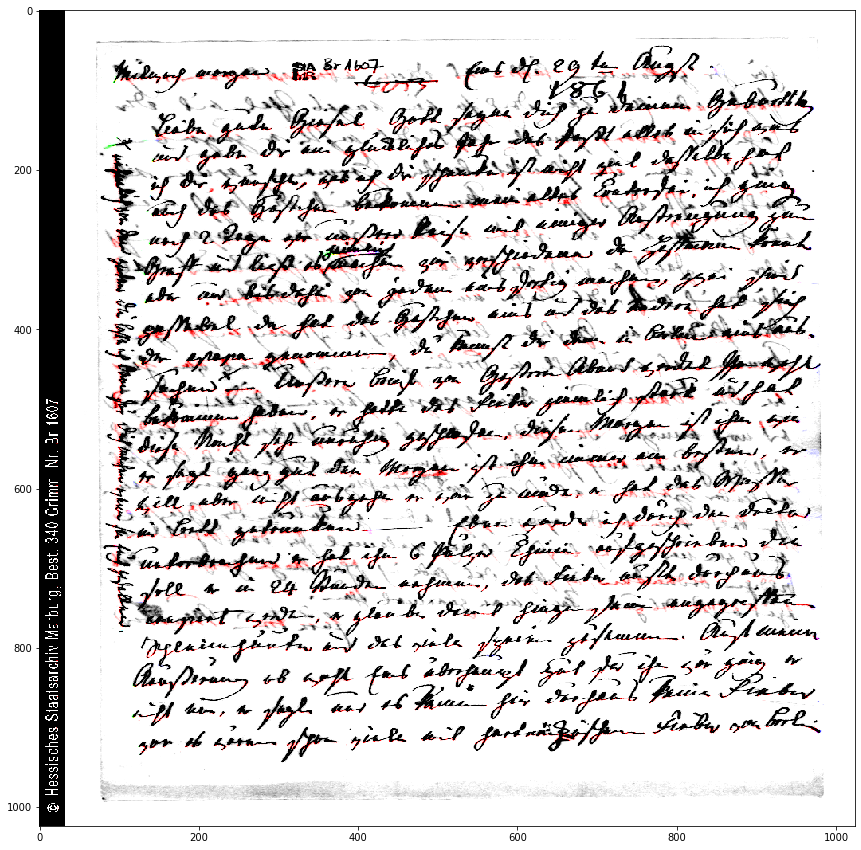

In [71]:
plt.figure(figsize=(15,15))
plt.imshow(image[0].permute(1,2,0).detach().numpy() + seg_out[[0, 3, 4],:,:].permute(1,2,0).detach().numpy())

In [153]:
start_points, end_points, angles, label_list = ld.extract_start_points_and_angles(seg_out.unsqueeze(0).detach().numpy())

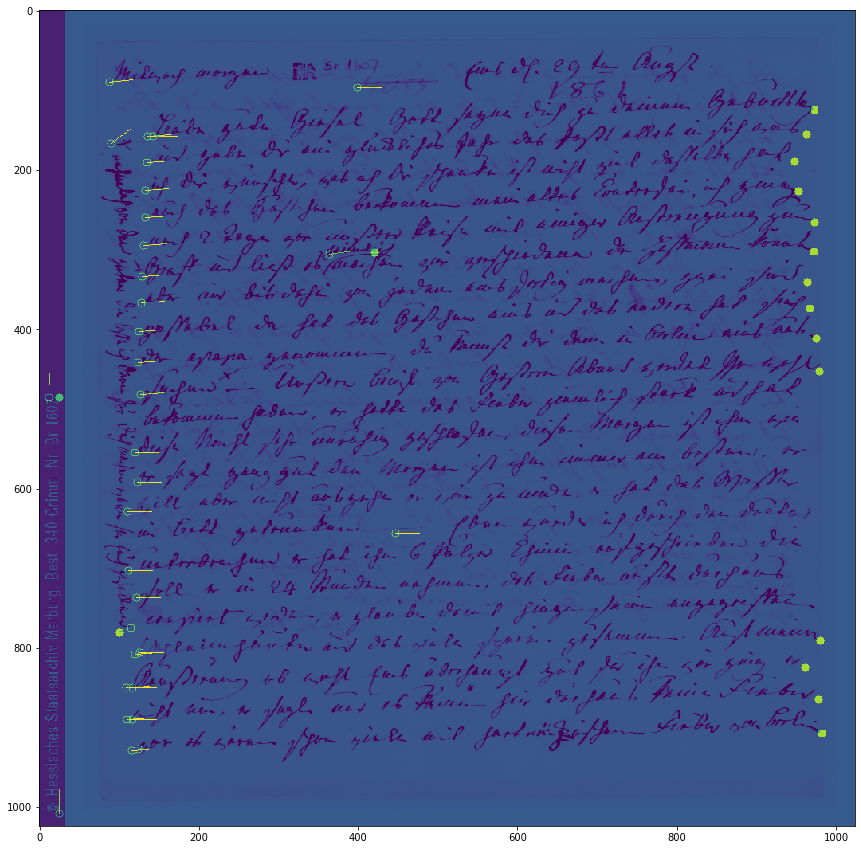

In [146]:
mask_img = np.zeros(image[0,0].shape, dtype=np.uint8)

for l in label_list:
    p = tuple(start_points[l].astype(int))
    cv2.circle(mask_img, p, radius=5, color=8, thickness=1, lineType=8, shift=0)
    angle = angles[l]
    p2 = (int(p[0] + 30*np.cos(angle)), int(p[1] - 30*np.sin(angle)))
    cv2.line(mask_img, p, p2, color=12)
    
    if l in end_points.keys():
        p = end_points[l]
        cv2.circle(mask_img, tuple(p.astype(int)), radius=5, color=10, thickness=-1, lineType=8, shift=0)
        
    
#for n, s in enumerate(new_sp):
#    p = tuple(s)
#    cv2.circle(mask_img, p, radius=5, color=13, thickness=-1, lineType=8, shift=0)
#    angle = new_angles[n]
#    p2 = (int(p[0] + 30*np.cos(angle)), int(p[1] - 30*np.sin(angle)))
#    cv2.line(mask_img, p, p2, color=12)
    
    
plt.figure(figsize=(15,15))
plt.imshow(mask_img+image[0,0,:,:].detach().numpy())

In [147]:
seg_out.shape

torch.Size([7, 1024, 1024])

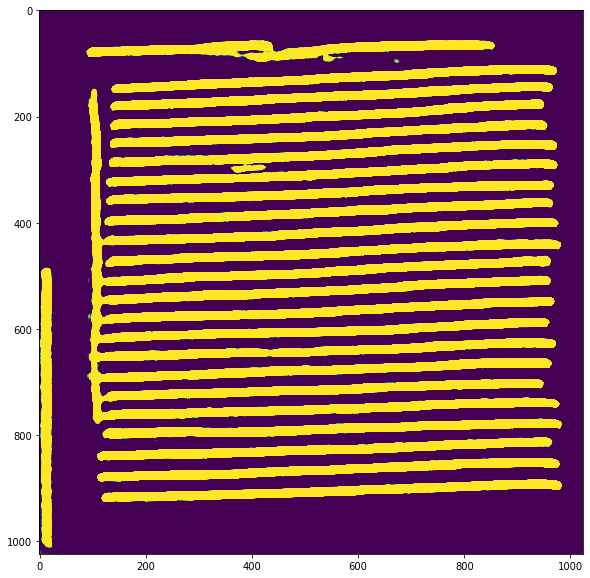

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(seg_out[5,:,:].detach().numpy())

In [22]:
# Postprozessing parameters
sigma = 0.3
threshold = 0.99
morph_close_size = 3
erode_size = 3

In [49]:
def segmentation_postprocessing(array: np.array, sigma, threshold, morph_close_size, erode_size):
    out = cv2.GaussianBlur(array, (int(3 * sigma) * 2 + 1, int(3 * sigma) * 2 + 1), sigma)
    out = (out > threshold) * 1.0
    out = cv2.morphologyEx(out, cv2.MORPH_CLOSE, (morph_close_size, morph_close_size))
    out = cv2.erode(out, (erode_size, erode_size), iterations=2)

    return out

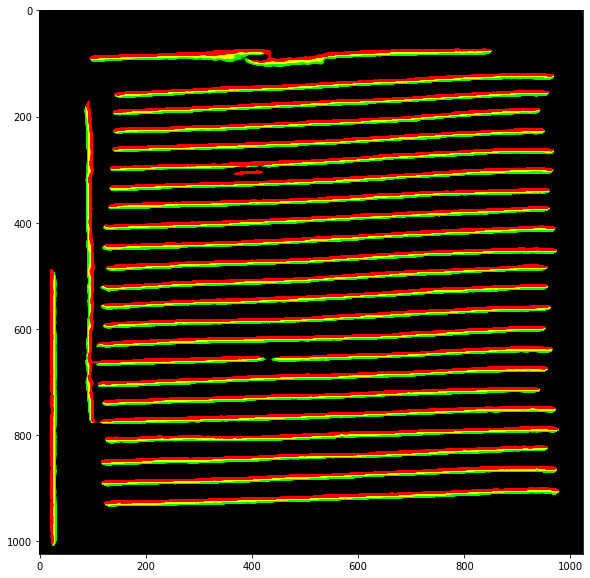

In [50]:
plt.figure(figsize=(10,10))
plt.imshow(seg_out_np[:,:,0:3])

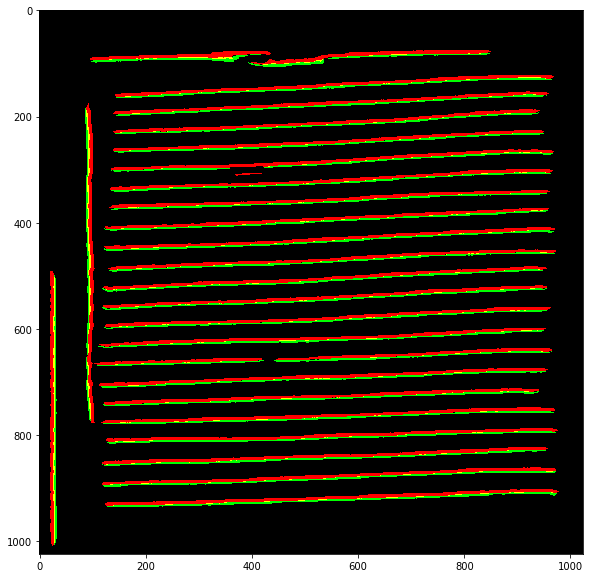

In [51]:
plt.figure(figsize=(10,10))
plt.imshow(segmentation_postprocessing(seg_out_np, sigma, threshold, morph_close_size*3, erode_size)[:,:,0:3])

In [24]:
def d2(x1, y1, x2, y2):
    """
    Computes the euclidian distance between the two points (x1, y1) and (x2, y2).
    """
    return torch.sqrt(pow(x1 - x2, 2) + pow(y1 - y2, 2))

def get_smallest_distance(point, point_list):
    d_min = 1e10

    for p in point_list:
        d = d2(p[0], p[1], point[0], point[1])
        if d > 0:
            d_min = min(d_min, d)

    return d_min

In [25]:
seg_out_np = seg_out.permute(1,2,0).detach().numpy()

In [26]:
out = segmentation_postprocessing(seg_out_np, sigma, threshold, morph_close_size, erode_size)

In [57]:
bl_seg = out[:,:,0]
border_seg = out[:,:,1]
text_seg = out[:,:,5]
start_seg = out[:,:,3]

bl_seg = out[:,:,0]+out[:,:,1]

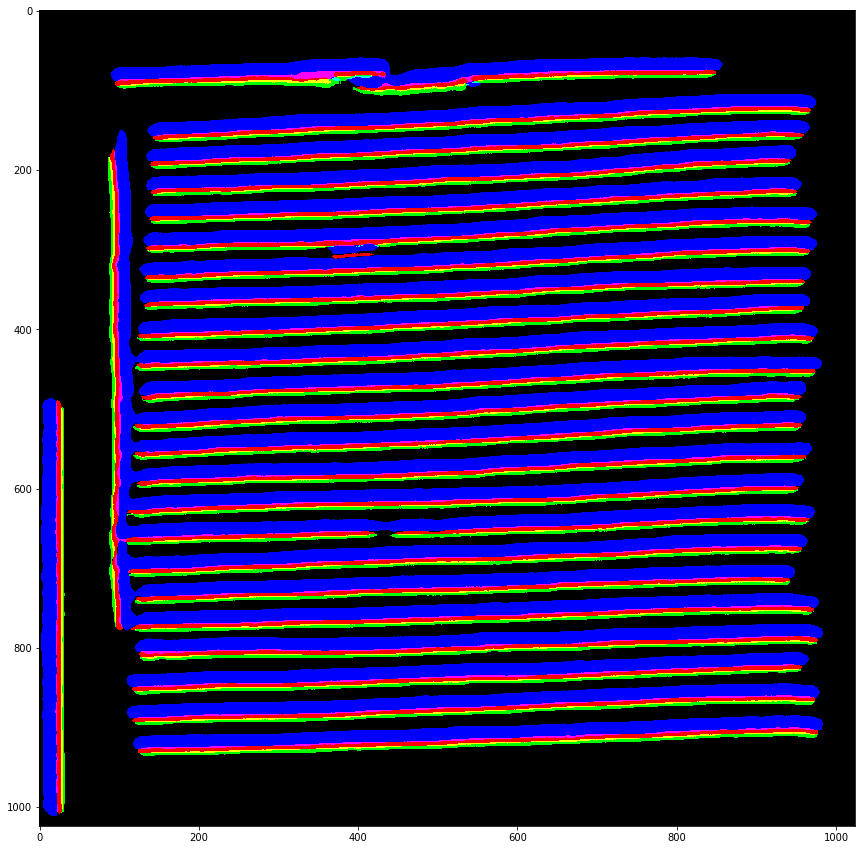

In [28]:
plt.figure(figsize=(15,15))
plt.imshow(out[:,:,[0,1,5]])

In [58]:
bl_num_labels, bl_labels, bl_stats, bl_centroids = cv2.connectedComponentsWithStats(bl_seg.astype(np.uint8))
border_num_labels, border_labels, border_stats, border_centroids = cv2.connectedComponentsWithStats(border_seg.astype(np.uint8))
text_num_labels, text_labels, text_stats, text_centroids = cv2.connectedComponentsWithStats(text_seg.astype(np.uint8))
start_num_labels, start_labels, start_stats, start_centroids = cv2.connectedComponentsWithStats(text_seg.astype(np.uint8))

bl_seg_num_labels, bl_seg_labels, bl_seg_stats, bl_seg_centroids = cv2.connectedComponentsWithStats(bl_seg.astype(np.uint8))

In [144]:
bl_stats[15]

array([ 121,  407,  851,   46, 8425], dtype=int32)

In [163]:
bl_stats

array([[     0,      0,   1024,   1024, 846863],
       [   394,     74,    456,     34,   4919],
       [    96,     76,    340,     23,   4099],
       [   143,    121,    827,     45,   8208],
       [   139,    152,    821,     47,   7856],
       [    86,    175,    338,    603,   9523],
       [   139,    186,    805,     48,   7775],
       [   138,    224,    813,     45,   7908],
       [   134,    261,    836,     44,   7991],
       [   398,    296,      1,      1,      1],
       [   400,    296,      1,      1,      1],
       [   133,    298,    835,     44,   8076],
       [   368,    305,     52,      7,    199],
       [   131,    338,    830,     38,   8028],
       [   123,    371,    837,     45,   8176],
       [   121,    407,    851,     46,   8425],
       [   128,    449,    847,     44,   8237],
       [   118,    481,    839,     49,   8213],
       [    20,    490,     13,    519,   5564],
       [   118,    517,    840,     48,   8251],
       [   123,    5

In [73]:
def is_in_box(point, left, top, width, height):
    x = point[0]
    y = point[1]
    
    if left < x < left+width:
        if top < y < top+height:
            return True
        
    return False

In [129]:
def contains_start_point(points, bl_stats):
    comp_contains_sp = []
    for n, bl_s in enumerate(bl_stats):
        
        left = bl_s[0]
        top = bl_s[1]
        width = bl_s[2]
        height = bl_s[3]
        
        if width > height:
            left -= 5
            width += 10
        else:
            top -= 5
            height += 10            
        
        contains_sp_switch = False
        for p in points:
            if is_in_box(p, left, top, width, height):
                comp_contains_sp.append(True)
                contains_sp_switch = True
                break
                
        if not contains_sp_switch:  
            comp_contains_sp.append(False)
        
    return comp_contains_sp

In [130]:
bl_out_truth = contains_start_point(start_centroids, bl_stats)

In [172]:
bl_centroids[4]

array([549.69348269, 175.44424644])

In [207]:
import math

new_sp = []
new_angles = []

for n, bl_s in enumerate(bl_stats):
    if not bl_out_truth[n]:
        
        left = bl_s[0]
        top = bl_s[1]
        width = bl_s[2]
        height = bl_s[3] 
        area = bl_s[4]
        
        if area < 3000:
            continue
            
        if width > height:
            for y in range(top, top+height):
                if bl_labels[y, left+1] == n:
                    new_sp.append([left, y])  
                    new_angles.append(0.0)
                    break
        else:
            y_direction = 0
            
            for x in range(left, left+width):
                if bl_labels[top+10, x] == n:
                    y_direction = -1
                    break
                elif border_labels[top+10, x] != 0:
                    y_direction = 1
                    break
                    
            if y_direction < 0: #from bottom up
                for x in range(left, left+width):
                    if bl_labels[top+height-1, x] == n:
                        new_sp.append([x, top+height-1])   
                        new_angles.append(math.pi/2)
                        break
            elif y_direction > 0: #from up to down
                for x in range(left, left+width):
                    if bl_labels[top+1, x] == n:
                        new_sp.append([x, top+1])   
                        new_angles.append(-math.pi/2)
                        break
        

In [208]:
new_angles

[0.0, 0.0, 1.5707963267948966, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [197]:
new_sp

[[96, 89],
 [121, 447],
 [20, 447],
 [118, 558],
 [111, 629],
 [441, 659],
 [112, 703],
 [121, 738],
 [115, 775]]

In [188]:
new_sp

[[96, 89],
 [121, 447],
 [118, 558],
 [111, 629],
 [441, 659],
 [112, 703],
 [121, 738],
 [115, 775]]

In [131]:
len(bl_stats)

30

In [132]:
bl_out_truth

[True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True]

In [133]:
sum(bl_out_truth*1)

18

In [134]:
len(start_centroids)

18

In [135]:
start_centroids

array([[510.69489553, 516.12094078],
       [469.81452577,  74.51311256],
       [555.7491063 , 129.47209455],
       [549.34436697, 163.52807339],
       [508.49001585, 589.34050297],
       [544.58867529, 199.53975615],
       [544.75304787, 235.55902468],
       [550.54199637, 271.57255898],
       [551.68807608, 308.15991222],
       [392.94107143, 299.0125    ],
       [547.42449128, 344.38989826],
       [544.54681485, 381.34284884],
       [553.54607801, 456.9885698 ],
       [ 13.35505251, 746.31467319],
       [546.40543585, 789.21560344],
       [535.64509246, 828.22937411],
       [544.38533399, 866.29479525],
       [552.09993002, 906.43463961]])

In [30]:
def d2(x1, y1, x2, y2):
    """
    Computes the euclidian distance between the two points (x1, y1) and (x2, y2).
    """
    return np.sqrt(pow(x1 - x2, 2) + pow(y1 - y2, 2))

def get_closest_point(point, point_list):
    d_min = 1e10
    n_closest = 0

    for n in range(len(point_list)):
        p = point_list[n]
        d = d2(p[0], p[1], point[0], point[1])
        if d > 0 and d < d_min:
            d_min = d
            n_closest = n

    return n_closest, d_min

In [31]:
area_threshold = 1000

for bl in range(bl_num_labels):
    stats = bl_stats[bl]
    
    if stats[4] < area_threshold:
        continue
    else:
        centroid = bl_centroids[bl]
        border_label, _ = get_closest_point(centroid, border_centroids)
        print('bl: {}; border: {}'.format(bl, border_label))
        print(centroid-border_centroids[border_label])

bl: 0; border: 0
[ 0.06968083 -0.18273082]
bl: 1; border: 1
[-79.23913529   2.70130415]
bl: 2; border: 2
[ 2.76961375 -3.85654589]
bl: 3; border: 4
[-2.11099385 -2.68545858]
bl: 4; border: 5
[-2.40918672 -2.60474154]
bl: 5; border: 6
[56.25544272 72.28175427]
bl: 6; border: 7
[ 0.81862388 -2.76794465]
bl: 7; border: 8
[-1.88482829 -2.64923227]
bl: 8; border: 8
[ 9.24923043 32.88205804]
bl: 11; border: 15
[-0.92422707 -2.6843494 ]
bl: 13; border: 16
[ 0.23895385 -2.7451298 ]
bl: 14; border: 17
[ 2.6222025  -2.83516415]
bl: 15; border: 18
[ 3.16124831 -2.92884356]
bl: 16; border: 19
[ 0.33968115 -2.75057454]
bl: 17; border: 20
[ 1.74508597 -2.8102713 ]
bl: 18; border: 21
[-3.20773528 -6.74970459]
bl: 19; border: 22
[ 1.18816009 -2.82087111]
bl: 20; border: 23
[-0.26009207 -2.77240699]
bl: 21; border: 24
[-3.4361386 -2.6639845]
bl: 22; border: 25
[ 9.28825603 -2.96128942]
bl: 23; border: 27
[ 0.16980543 -2.78065195]
bl: 24; border: 28
[ 0.41496823 -2.78125821]
bl: 25; border: 29
[-1.42904

In [129]:
bl_stats[0]

array([     0,      0,   1024,   1024, 970679], dtype=int32)

In [112]:
bl_num_labels

16

In [113]:
border_num_labels

16

In [115]:
text_num_labels

17

In [120]:
bl_c_dict = {l: bl_centroids[l] for l in range(bl_num_labels)}

In [ ]:
border_to_bl_dict = {l: bl_seg}

In [116]:
bl_centroids

array([[512.79488121, 514.2208111 ],
       [525.84036048, 117.10894754],
       [497.23974189, 192.84877565],
       [251.74081091, 270.2171277 ],
       [505.885233  , 333.37956549],
       [525.83215866, 412.67218489],
       [503.92494824, 489.2600069 ],
       [567.03622047, 567.37007874],
       [511.32514907, 642.06681866],
       [324.08357257, 721.04593301],
       [757.92959087, 774.7659372 ],
       [346.08239376, 786.03873952],
       [735.45780051, 831.77621483],
       [681.        , 833.5       ],
       [391.04077762, 847.49359886],
       [734.7365224 , 896.25132878]])

In [109]:
stats

array([[     0,      0,   1024,   1024, 996603],
       [    97,    101,    849,     31,   6214],
       [    91,    179,    811,     32,   6044],
       [    83,    260,    337,     21,   2639],
       [    87,    315,    846,     36,   6352],
       [   107,    398,    835,     28,   6101],
       [   111,    474,    784,     29,   5796],
       [   477,    563,    183,     10,   1270],
       [   105,    630,    818,     25,   5702],
       [   113,    715,    421,     14,   3135],
       [   683,    769,    148,     12,   1051],
       [   123,    777,    439,     18,   3459],
       [   683,    827,    108,     10,    782],
       [   681,    833,      1,      2,      2],
       [   249,    843,    273,     10,   2109],
       [   649,    891,    168,     12,   1317]], dtype=int32)

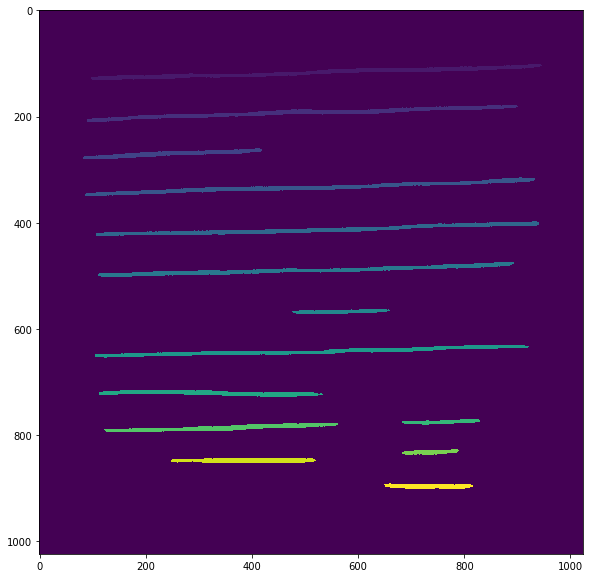

In [110]:
plt.figure(figsize=(10,10))
plt.imshow(labels)